<a href="https://colab.research.google.com/github/imirenechen/DS-Projects/blob/main/Project-6%20OpenCV_HOG%2BSVM_Face_Detection_with_SVM_score_based_NMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Face Detection using HOG+SVM:
In this example, we will take a look at one such feature extraction technique, the [Histogram of Oriented Gradients](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) (HOG), which transforms image pixels into a vector representation that is sensitive to broadly informative image features regardless of confounding factors like illumination.
We will use these features together with SVM to develop a simple face detector. 



(300, 451)


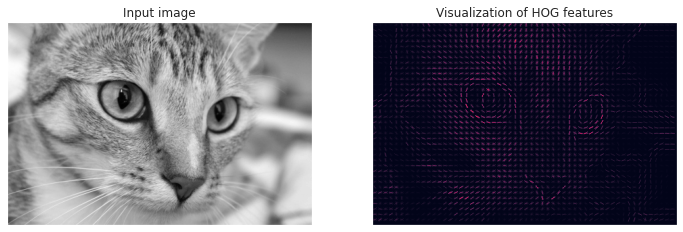

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from skimage import data, color, feature
import skimage.data
%matplotlib inline

image = color.rgb2gray(data.chelsea())
print(image.shape)
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Input image')

ax[1].imshow(hog_vis)
ax[1].set_title('Visualization of HOG features');

### 1. Obtain a set of positive training samples

Let's start by finding some positive training samples that show a variety of faces.
We have one easy set of data to work with—the Labeled Faces in the Wild dataset, which can be downloaded by Scikit-Learn:

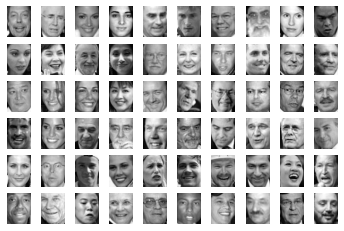

In [ ]:
from sklearn.datasets import fetch_lfw_people
from google.colab.patches import cv2_imshow

# download label faces in the wild dataset
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape # (13233,62,47) where each image is with size 47*62 (W*H)
#cv2_imshow(positive_patches[0])

# show postive images
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(positive_patches[50 * i], cmap='gray')
    axi.axis('off')

### 2. Obtain a set of negative training samples
Next we need a set of similarly sized thumbnails which do not have a face in them. One way to do this is to take any corpus of input images, and extract thumbnails from them at a variety of scales. Here we can use some of the images (The USC-SIPI Image Database) shipped with Scikit-Image, along with Scikit-Learn's PatchExtractor: 

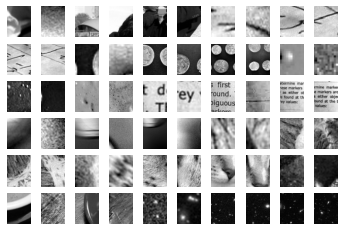

In [ ]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
        'page', 'clock', 'immunohistochemistry',
        'chelsea', 'coffee', 'hubble_deep_field']
# download negative image sources: no faces inside each image
# the image size is 512*512
# images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]
images = []
for name in imgs_to_use:
  img = getattr(data, name)()
  if len(img.shape) == 3:
    img = color.rgb2gray(img)
  images.append(img)

from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    # patches are cropped with the postive training image size mulitplied with scale factor
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
   
    # transform the image (1*H*W) to designated size 62*47*scale
    patches = extractor.transform(img[np.newaxis])   
    # rescale to the same size if patches are cropped with scale other than 1
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

# horizontally concatenate images originally cropped with different scales
# images come from 10 classes (images), each of which will be cropped with 3 different scales
# Totally images 1000*3*10 = 30000
negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

# show cropped negative training images
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [ ]:
# giving labels for postive and negative images
from itertools import chain

# hog size: blocks: 3*3; pixels in each block: 8; stride=1 block; bins for each block=9
# total blocks: floor((62-24)/8)+1=5; floor((47-24)/8)+1=3
# total feature size = 5*3*9*9 = 1215
X_train = np.array([feature.hog(im) for im in chain(positive_patches, negative_patches)])

In [ ]:
print(positive_patches.shape)
print(negative_patches.shape)
print(X_train.shape)

(13233, 62, 47)
(30000, 62, 47)
(43233, 1215)


### 3. Perform training and load testing image:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#print(X_train.shape)
y_train = np.zeros(X_train.shape[0])
# top images are positive training data so their label will be set to 1
y_train[:positive_patches.shape[0]] = 1

# performing (SVM) classifier training
from sklearn.svm import LinearSVC
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

# brute-force for all hyper parameters in training SVM
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=2.0)

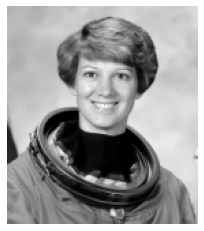

In [ ]:
# show and crop test image
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]
#print(type(test_image))

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [ ]:
from google.colab import drive
import os

drive.mount("/content/drive")
path = "/content/drive/MyDrive/Colab Notebooks"
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(-0.5, 79.5, 89.5, -0.5)

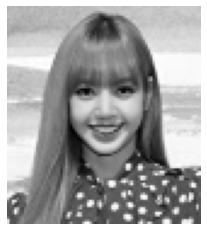

In [ ]:
from PIL import Image
import numpy as np
#from IPython.display import Image, display

test_image = Image.open("Test-4.jpg")
#display(test_image)
#test_image = np.array(test_image)

test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[10:100, 70:150]
#print(type(test_image))

plt.imshow(test_image, cmap='gray')
plt.axis('off')

### 4. Perform detection by iteratively cropping images and classifying them:

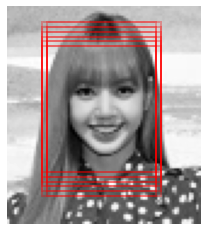

In [ ]:
# crop images in sliding window fasion
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
# print(patches_hog.shape)

# Classification mehod 1: obtain classification results directly
# labels = model.predict(patches_hog)
# prob = model.predict_proba(patches_hog)
# print(prob)
# labels.sum()

# Classification mehod 2: obtain w & b first, then do wx+b manually classification results 
# SVM score for the later NMS
svm_w = model.coef_[0]
svm_intercept = model.intercept_[0]

# svm_w is 1-d array
svm_w_reshaped = svm_w.reshape(1215,1)

# perform mx+b
svm_score = np.matmul(patches_hog,svm_w_reshaped) + svm_intercept
labels = np.copy(svm_score.reshape(-1,)) # make a 1-d array for label array
# perform classification
labels[labels>0] = 1
labels[labels<0] = -1
svm_score = svm_score[labels==1] # only svm_score>1 will be involved in the later NMS

# overlapping bounding boxes on the test images
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

# get the size of the result
numBBox, _ = indices[labels == 1].shape

# initialize the numpy array to store x_top_left,y_top_right,x_btm_right,y_btm_right
BBox_array = np.zeros((numBBox,4))

#print(numBBox)

running_index = 0

# overlapping bounding boxes as well as store raw detection results
for i, j in indices[labels == 1]:
    #print(i,j)
    BBox_array.itemset((running_index,0),j) 
    BBox_array.itemset((running_index,1),i) 
    BBox_array.itemset((running_index,2),j+Nj) 
    BBox_array.itemset((running_index,3),i+Ni) 
    running_index = running_index + 1 
        
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))
    
#print(BBox_array.shape)
#print(BBox_array)
#print(svm_score.shape)
#print(svm_score)

### 5. Apply Non-Maximal-Suppression for eliminating multiple/redundant outputs:

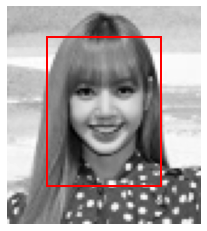

In [ ]:
# do non-maximal-suppression for producing the only output bounding box
def non_max_suppression_fast(boxes, svm_score, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
 
  # sorting by y2: old version; didn't make sense
	#print(y2.shape)
	#idxs = np.argsort(y2)
  
	# sorting according to svm_score: new version ; make sense
	#print(svm_score.shape)
	svm_score = svm_score.reshape(-1,) # make it a 1-day array
	idxs = svm_score.argsort() #this is ascending
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
 
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

# doing non-maxmal suppression to eliminate redundant bbox

NMS_result = non_max_suppression_fast(BBox_array, svm_score, 0.5)

# fetch the number of remained bounding box
NMS_result_num, _ = NMS_result.shape

#print(NMS_result)

# do remind that the original image size and the image shown might be different
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for i in range(NMS_result_num):
        
    x = NMS_result[i,0]
    y = NMS_result[i,1]
    w = NMS_result[i,2] - NMS_result[i,0]
    h = NMS_result[i,3] - NMS_result[i,1]
    ax.add_patch(plt.Rectangle((x, y), w, h, edgecolor='red',
                               linewidth=5, lw=2, facecolor='none'))

### 人臉辨識結果討論
- 紅框有把人臉框住，但是大小太大，可能會包含其他背景或物體的雜訊，而降低判斷的準確度
- 且框框較大，可能需要處理較多資料而降低速度
- (有使用其他照片做測試，紅框大小好像也會跟圖片的解析度或大小有關)